In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch_geometric.transforms as T
from torch import lgamma
from torch_geometric.data import DataLoader
from torch_scatter import scatter_mean
import argparse
import numpy as np
import random
import ogb
from ogb.graphproppred import PygGraphPropPredDataset

parser = argparse.ArgumentParser(description='PyTorch implementation of neural graph fingerprint generation')
args = parser.parse_args("")
args.device = 3
args.device = torch.device('cuda:'+ str(args.device) if torch.cuda.is_available() else 'cpu')
print("device:", args.device)
torch.manual_seed(0)
np.random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed = 0
set_seed(seed)

device: cuda:3


In [8]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

class NeuralGraphFingerprint(MessagePassing):
    def __init__(self):
        super(NeuralGraphFingerprint, self).__init__(aggr='add')  # "Add" aggregation.

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
    
        # Add self-loops to the adjacency matrix.
        # This is to ensure that current node's features are part of aggregation
        # (i.e. include node a in its neighborhood)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Start propagating messages.
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # x_j has shape [E, out_channels]
        return x_j

In [43]:
class AttrProxy(object):
    """Translates index lookups into attribute lookups."""
    def __init__(self, module, prefix):
        self.module = module
        self.prefix = prefix

    def __getitem__(self, i):
        return getattr(self.module, self.prefix + str(i))

In [46]:
from torch_geometric.nn import GCNConv
from ogb.graphproppred.mol_encoder import AtomEncoder

class Net(torch.nn.Module):
    # Fixed fingerprints must be extremely large to encode all possible substructures without overlap
    def __init__(self, mode='ngf', num_features=2048, max_layers=5):
        super(Net, self).__init__()
        
        self.mode = mode
        self.max_layers = max_layers
        
        self.atom_encoder = AtomEncoder(emb_dim=num_features)
        
        for L in range(max_layers):
            if mode == 'ngf':
                self.add_module('conv_' + str(L), NeuralGraphFingerprint())
            elif mode == 'gcn':
                self.add_module('conv_' + str(L), GCNConv(num_features, num_features))
            else:
                raise NotImplementedError
            
            # TODO: fixed large random weights
            self.add_module('hlin_' + str(L), torch.nn.Linear(num_features, num_features))
            self.add_module('olin_' + str(L), torch.nn.Linear(num_features, num_features))
        
        self.convs = AttrProxy(self, 'conv_')
        self.hidden_weights = AttrProxy(self, 'hlin_')
        self.output_weights = AttrProxy(self, 'olin_')
            
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # TODO: fingerprints are identical regardless of the ordering of atoms in each neighborhood
        # this invariance is achieved by sorting the neighboring atoms according to their features, and bond features
        
        # does not make use of edge attributes
        h = self.atom_encoder(x)
        f = torch.zeros(h.size()).to(args.device)
        reprs = []
        # should change to only interate up to L_max = minimum eccentricity (i.e. radius of molecule)
        for L in range(self.max_layers):
            h = self.convs[L](h, edge_index)
            h = self.hidden_weights[L](h).sigmoid()
            h = self.output_weights[L](h).softmax(dim=1)
            f += h
            reprs.append(f)
        
        return f, reprs

Loading data...
dataset: ogbg-moltox21 


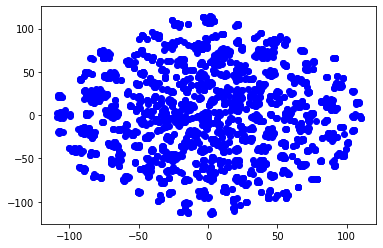

In [52]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

args.dataset = 'ogbg-moltox21'
args.n_classes = 1
args.batch_size = 128

print("Loading data...")
print("dataset: {} ".format(args.dataset))
dataset = PygGraphPropPredDataset(name=args.dataset).shuffle()

loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False, drop_last=True)
model = Net().to(args.device)

for idx, data in enumerate(loader):
    
    data = data.to(args.device)
    f, reprs = model(data)
    
    tsne = TSNE()
    proj = tsne.fit_transform(torch.cat(reprs).detach().cpu().numpy())
    colors = ['b', 'g', 'r', 'c', 'm']
    offset = 0
    for repr_idx, r in enumerate(reprs):
        plt.scatter(proj[offset:r.size(0),0], proj[offset:r.size(0),1], color=colors[repr_idx])      
        offset += r.size(0)
    
    plt.show()
    break